In [10]:
# export full genome
from pybedtools import genome_registry, chromsizes_to_file, chromsizes
chromsizes_to_file(chromsizes('hg19'), '../download/genome/hg19.genome')

'../download/genome/hg19.genome'

In [11]:
assembly_path = "../download/genome/hg19_reduced.genome"

In [12]:
import pandas as pd
import numpy as np
from pybedtools import BedTool

In [132]:
fantom_bed = BedTool("../download/FANTOM/permissive_enhancers.bed")

In [138]:
repeat_bed_df = pd.read_hdf("../storage/repeatmasker_staging.hdf", "SINE_Alu_bed")
repeat_bed = BedTool().from_dataframe(repeat_bed_df)

In [15]:
fantom_bed.head()

chr1	858256	858648	chr1:858256-858648	5	.	858447	858448	0,0,0	2	1,10	0,382
 chr1	918449	918555	chr1:918449-918555	18	.	918504	918505	0,0,0	2	7,1	0,105
 chr1	941791	942135	chr1:941791-942135	2	.	942081	942082	0,0,0	2	238,1	0,343
 chr1	945769	946034	chr1:945769-946034	17	.	945889	945890	0,0,0	2	1,25	0,240
 chr1	956563	956812	chr1:956563-956812	143	.	956664	956665	0,0,0	2	57,102	0,147
 chr1	1005293	1005547	chr1:1005293-1005547	66	.	1005420	1005421	0,0,0	2	57,55	0,199
 chr1	1014834	1015095	chr1:1014834-1015095	17	.	1014858	1014859	0,0,0	2	1,213	0,48
 chr1	1060905	1061095	chr1:1060905-1061095	7	.	1060999	1061000	0,0,0	2	1,1	0,189
 chr1	1063914	1064111	chr1:1063914-1064111	50	.	1063978	1063979	0,0,0	2	45,112	0,85
 chr1	1093610	1093958	chr1:1093610-1093958	7	.	1093953	1093954	0,0,0	2	341,1	0,347
 

In [16]:
fantom_bed.count()

43011

In [17]:
repeat_bed.count()

1177252

In [18]:
encode_bed_df = fantom_bed.to_dataframe()

## Alu-enhancers: core of enhancers in Alu

In [19]:
def compute_centers(df):
    df['centered_locus'] = round(
        (df['end'] - df['start'])/2 
        + df['start']).astype(int)

In [20]:
compute_centers(encode_bed_df)

In [21]:
encode_bed_cores_df = encode_bed_df.copy()
encode_bed_cores_df['start'] = encode_bed_cores_df['centered_locus']
encode_bed_cores_df['end'] = encode_bed_cores_df['centered_locus']

In [22]:
encode_bed_cores = BedTool().from_dataframe(encode_bed_cores_df[['chrom', 'start', 'end', 'name', 'score', 'strand']])

In [23]:
encode_bed_cores.count()

43011

In [24]:
#MIR-enhancers: core of enhancer in MIR
core_intersection = encode_bed_cores.intersect(repeat_bed)

In [25]:
core_intersection.count()

1491

In [26]:
core_intersection.head()

chr1	1456688	1456688	chr1:1456676-1456699	3	.
 chr1	3582221	3582221	chr1:3582035-3582407	58	.
 chr1	5184486	5184486	chr1:5184476-5184496	3	.
 chr1	6709155	6709155	chr1:6709089-6709221	3	.
 chr1	7947792	7947792	chr1:7947650-7947935	3	.
 chr1	8445964	8445964	chr1:8445817-8446112	16	.
 chr1	8858342	8858342	chr1:8858188-8858497	13	.
 chr1	9030241	9030241	chr1:9030064-9030418	46	.
 chr1	9765464	9765464	chr1:9765379-9765549	7	.
 chr1	9889708	9889708	chr1:9889535-9889880	9	.
 

In [27]:
# null model MIR-enhancers
shuffled_encode_bed_cores = encode_bed_cores.shuffle(g=assembly_path)
core_null_model_intersection = shuffled_encode_bed_cores.intersect(repeat_bed)

In [28]:
core_null_model_intersection.count()

4231

In [29]:
def compute_size(row, prefix=None):
    col_name = prefix + '_name' if prefix else 'name'
    if row[col_name] == '.':
        return 0
    col_end = prefix + '_end' if prefix else 'end'
    col_start = prefix + '_start' if prefix else 'start'
    size = abs(row[col_end] - row[col_start])
    return size

def mean_size(bed):
    sample_df = bed.to_dataframe()
    sample_df['size'] = sample_df.apply(lambda row: compute_size(row), axis=1)
    return int(round(sample_df[['size']].mean()))

def build_random_overlap(bed, intervals_size, intervals_num, min_overlap, assembly, df_columns, idx):
    empty_bed = BedTool()
    random_bed = empty_bed.random(l=intervals_size, n=intervals_num,
                                  g=assembly)
    row_array = [idx, bed.intersect(random_bed, f=min_overlap).count()]
    return pd.DataFrame([row_array], columns=df_columns)

def build_shuffled_overlap(bed, bed_overlap_with, min_overlap, assembly, df_columns, idx):
    random_bed = bed_overlap_with.shuffle(g=assembly, chrom=False)
    row_array = [idx, bed.intersect(random_bed, f=min_overlap).count()]
    return pd.DataFrame([row_array], columns=df_columns)

In [30]:
from joblib import Parallel, delayed
import multiprocessing

def create_random_overlap_distribution_parallelized(bed, bed_overlap_with, assembly, min_overlap, 
                                                    samples_num,strategy='random'):
    num_cores = multiprocessing.cpu_count()

    intervals_size = mean_size(bed_overlap_with)
    intervals_num = bed_overlap_with.count()
    columns = ['sample_num', 'size']

    if strategy == 'shuffle':
        df_list = Parallel(n_jobs=num_cores)(delayed(build_shuffled_overlap)
                                             (bed, bed_overlap_with, min_overlap, assembly, columns, i)
                                             for i in range(0, samples_num))
    else:
        df_list = Parallel(n_jobs=num_cores)(delayed(build_random_overlap)
                                             (bed, intervals_size, intervals_num, min_overlap, assembly, columns, i)
                                             for i in range(0, samples_num))
    return pd.concat(df_list)

In [31]:
test_df = create_random_overlap_distribution_parallelized(encode_bed_cores, repeat_bed, assembly_path,
                                                         1e-09, 100)

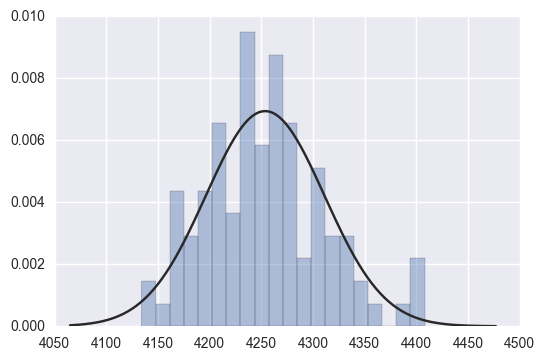

In [32]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(test_df[['size']], kde=False, fit=st.norm, bins=20)

In [33]:
z_score =(core_intersection.count() - np.mean(test_df['size']))/np.std(test_df['size'])
print(z_score)

-48.06658921593253


In [34]:
import scipy.stats as st
st.norm.ppf(.95)
st.norm.cdf(z_score)

0.0

In [35]:
p_values = st.norm.sf(abs(z_score))
p_values

0.0

In [36]:
st.ttest_1samp(a= test_df[['size']], popmean= core_intersection.count())

Ttest_1sampResult(statistic=array([ 478.25652414]), pvalue=array([  2.46222596e-168]))

In [37]:
st.ttest_1samp(a= test_df[['size']], popmean= np.mean(test_df[['size']]))

Ttest_1sampResult(statistic=size    0.0
dtype: float64, pvalue=array([ 1.]))

In [38]:
chi2, p = st.chisquare( test_df[['size']],core_intersection.count() )
msg = "Test Statistic: {}\np-value: {}"
print( msg.format( chi2, p ) )

Test Statistic: [ 512153.03755869]
p-value: [ 0.]


In [39]:
encode_bed_cores.sort().fisher(repeat_bed.sort(), f=1e-09, g=assembly_path)

<FisherOutput at 5054166800>
# Number of query intervals: 43011
# Number of db intervals: 1177159
# Number of overlaps: 1491
# Number of possible intervals (estimated): 11763207
# phyper(1491 - 1, 43011, 11763207 - 43011, 1177159, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 1491         | 41520        |
# not in -a | 1175668      | 10544528     |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0	1	0	0.322

In [40]:
1-st.hypergeom.cdf(975, 21123880 - 33082, 33082, 593161)

0.067519672328844149

In [41]:
df_reldist = pd.DataFrame(encode_bed_cores.sort().reldist(repeat_bed.sort()))
df_reldist.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,356.000,384.000,472.000,497.000,560.000,579.000,650.000,686.000,679.000,702.000,...,1013.000,1035.000,1040.000,986.000,987.000,988.000,1028.000,926.000,1020.000,13.0
fraction,0.008,0.009,0.011,0.012,0.013,0.013,0.015,0.016,0.016,0.016,...,0.024,0.024,0.024,0.023,0.023,0.023,0.024,0.022,0.024,0.0
reldist,0.000,0.010,0.020,0.030,0.040,0.050,0.060,0.070,0.080,0.090,...,0.410,0.420,0.430,0.440,0.450,0.460,0.470,0.480,0.490,0.5
total,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,...,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.0


In [42]:
df_reldist_random = pd.DataFrame(encode_bed_cores.sort().reldist(repeat_bed.shuffle(g=assembly_path, chrom=False).sort()))

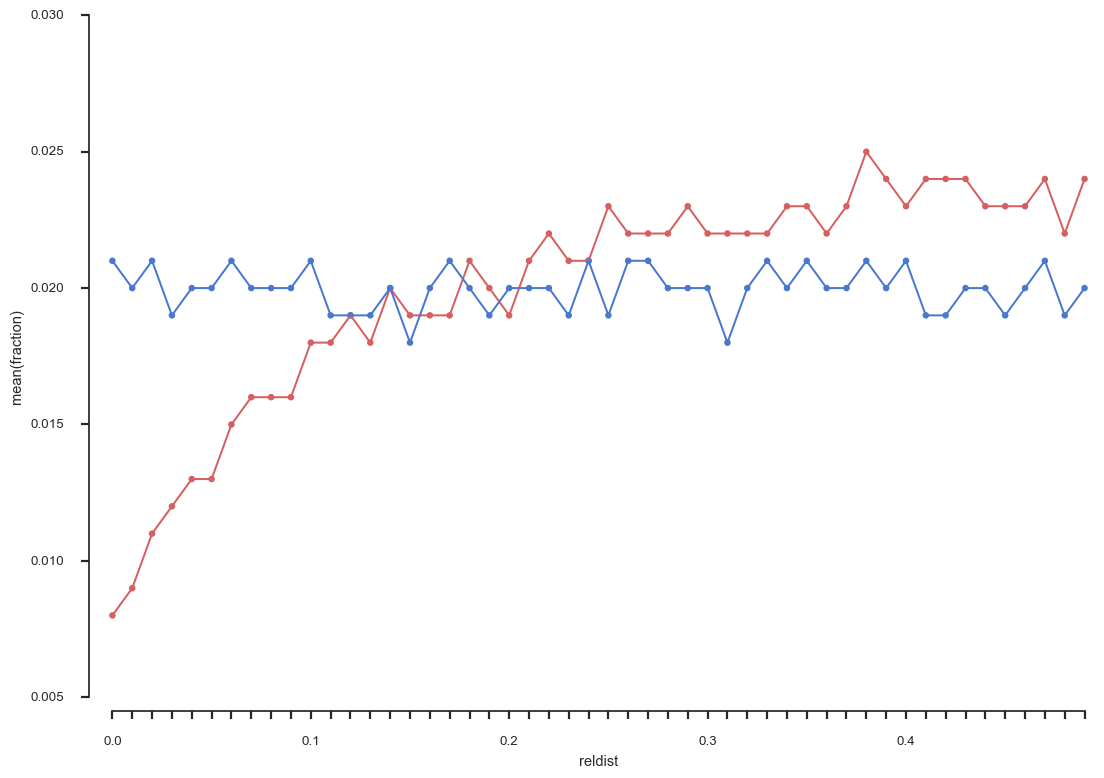

In [43]:
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="ticks", palette="muted", color_codes=True)
sns.set_context("poster", font_scale=0.6, rc={"lines.linewidth": 0.8})

g1 = sns.pointplot(x='reldist', y='fraction', data=df_reldist[0:50],  color='r')
g2 = sns.pointplot(x='reldist', y='fraction', data=df_reldist_random[0:50], color='b')

sns.despine(offset=10, trim=True)
#plot.set_yscale("log")
#df_reldist[['reldist','fraction']].plot()
for ind, label in enumerate(g1.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## Enhancer-Alus: Alus in a +/- 4 kbp window around enhancer's core 

In [44]:
encode_bed_df = fantom_bed.to_dataframe()
encode_bed_df['size'] = encode_bed_df.apply(lambda row: compute_size(row), axis=1)

In [45]:
encode_bed_df['size'].quantile(0.5) == encode_bed_df['size'].median()

True

In [46]:
encode_bed_df['size'].std()

163.37426764008453

/Users/manuel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


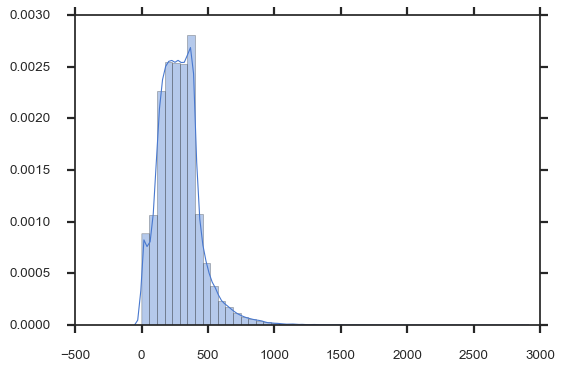

In [47]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(encode_bed_df[['size']], kde=True)

In [48]:
np.percentile(encode_bed_df[['size']], 50)

275.0

In [49]:
np.arange(0, 1, 0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [50]:
encode_bed_df[['size']].quantile(np.arange(0,1,0.1))

,size
0.0,2.0
0.1,109.0
0.2,157.0
0.3,197.0
0.4,236.0
0.5,275.0
0.6,315.0
0.7,354.0
0.8,390.0
0.9,462.0


In [51]:
# what if using percentiles in considering enhancer regions? Eg: b=170/2, 251/2, ..., 3123/2
#encode_bed_slop = encode_bed_cores.slop(genome='hg19', b=int(round(3123/2)))

In [97]:
#compute "enhancers regions" as +/- 4kb from enhancer cores
encode_bed_slop = encode_bed_cores.slop(g=assembly_path, b=1500)

In [98]:
encode_bed_cores.sort().head()

chr1	858452	858452	chr1:858256-858648	5	.
 chr1	918502	918502	chr1:918449-918555	18	.
 chr1	941963	941963	chr1:941791-942135	2	.
 chr1	945902	945902	chr1:945769-946034	17	.
 chr1	956688	956688	chr1:956563-956812	143	.
 chr1	1005420	1005420	chr1:1005293-1005547	66	.
 chr1	1014964	1014964	chr1:1014834-1015095	17	.
 chr1	1061000	1061000	chr1:1060905-1061095	7	.
 chr1	1064012	1064012	chr1:1063914-1064111	50	.
 chr1	1093784	1093784	chr1:1093610-1093958	7	.
 

In [99]:
encode_bed_slop.sort().head()

chr1	856952	859952	chr1:858256-858648	5	.
 chr1	917002	920002	chr1:918449-918555	18	.
 chr1	940463	943463	chr1:941791-942135	2	.
 chr1	944402	947402	chr1:945769-946034	17	.
 chr1	955188	958188	chr1:956563-956812	143	.
 chr1	1003920	1006920	chr1:1005293-1005547	66	.
 chr1	1013464	1016464	chr1:1014834-1015095	17	.
 chr1	1059500	1062500	chr1:1060905-1061095	7	.
 chr1	1062512	1065512	chr1:1063914-1064111	50	.
 chr1	1092284	1095284	chr1:1093610-1093958	7	.
 

In [100]:
encode_bed_slop.count()

43011

In [101]:
#enhancer-MIRs: MIR in +/- 4kb from the core of an enhancer 
#(asking the full MIR to be overlapped by an enhancer region)
region_intersection = repeat_bed.intersect(encode_bed_slop, f=1)

In [102]:
region_intersection.count()

49323

In [103]:
# null model enhancers-MIRs
shuffled_repeat = repeat_bed.shuffle(g=assembly_path)

In [104]:
shuffled_repeat.count() == repeat_bed.count()

True

In [105]:
null_model_intersection = shuffled_repeat.intersect(encode_bed_slop, f=1)

In [106]:
null_model_intersection.count()

44791

In [107]:
test_df2 = create_random_overlap_distribution_parallelized(repeat_bed, encode_bed_slop, assembly_path,
                                                         1, 100)


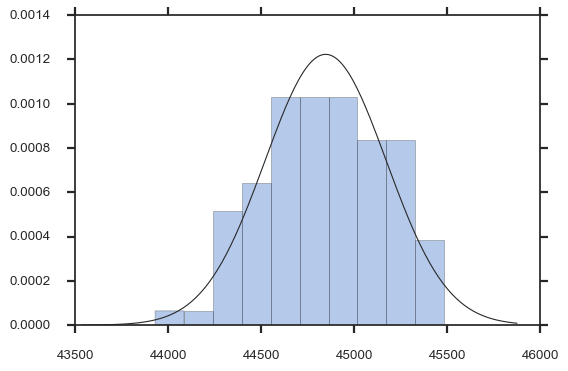

In [108]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(test_df2[['size']], kde=False, fit=st.norm, bins=10)

In [109]:
z_score =(region_intersection.count() - np.mean(test_df2['size']))/np.std(test_df2['size'])
print(z_score)

13.720213336415508


In [110]:
import scipy.stats as st
st.norm.ppf(.95)
st.norm.cdf(z_score)

1.0

In [111]:
p_values = st.norm.sf(abs(z_score))
p_values

3.841949102417058e-43

In [112]:
st.ttest_1samp(a= test_df2[['size']], popmean= region_intersection.count())

Ttest_1sampResult(statistic=array([-136.51439904]), pvalue=array([  1.55428151e-114]))

In [113]:
chi2, p = st.chisquare( test_df2[['size']],region_intersection.count() )
msg = "Test Statistic: {}\np-value: {}"
print( msg.format( chi2, p ) )

Test Statistic: [ 40838.74575756]
p-value: [ 0.]


In [114]:
repeat_bed.sort().fisher(encode_bed_slop.sort(), f=1, g=assembly_path)

<FisherOutput at 4971450552>
# Number of query intervals: 1177252
# Number of db intervals: 43011
# Number of overlaps: 49323
# Number of possible intervals (estimated): 1177252
# phyper(49323 - 1, 1177252, 1177252 - 1177252, 43011, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 49323        | 1127929      |
# not in -a | 0            | 0            |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1	1	nan

In [115]:
#pvalue <- 1-phyper(45, 92, 7518, 1329)
#pvalue = 1-stats.hypergeom.cdf(45, 7518, 92. 1329)
1-st.hypergeom.cdf(66741, 0, 594732, 33082)

0.0

In [116]:
df_reldist = pd.DataFrame(encode_bed_slop.sort().reldist(repeat_bed.sort()))
df_reldist.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,356.000,384.000,472.000,497.000,560.000,579.000,650.000,686.000,679.000,702.000,...,1013.000,1035.000,1040.000,986.000,987.000,988.000,1028.000,926.000,1020.000,13.0
fraction,0.008,0.009,0.011,0.012,0.013,0.013,0.015,0.016,0.016,0.016,...,0.024,0.024,0.024,0.023,0.023,0.023,0.024,0.022,0.024,0.0
reldist,0.000,0.010,0.020,0.030,0.040,0.050,0.060,0.070,0.080,0.090,...,0.410,0.420,0.430,0.440,0.450,0.460,0.470,0.480,0.490,0.5
total,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,...,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,43011.0


In [117]:
df_reldist_random = pd.DataFrame(encode_bed_slop.sort().reldist(repeat_bed.sort().shuffle(g=assembly_path, chrom=False).sort()))

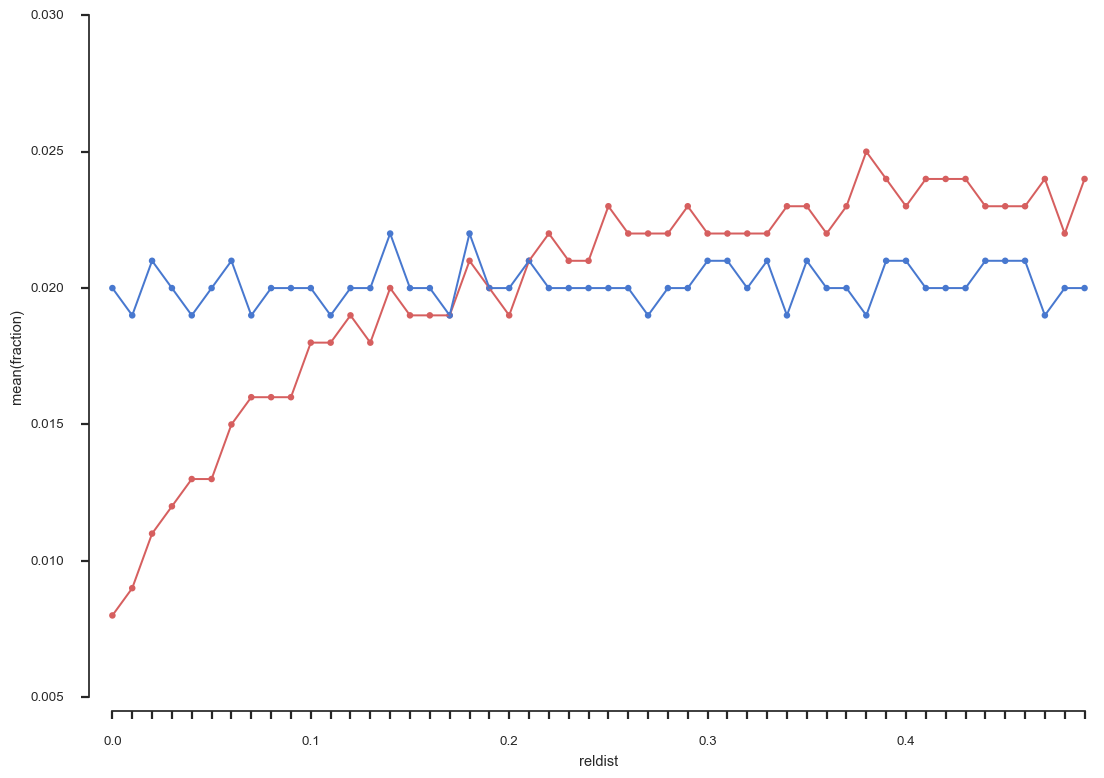

In [118]:
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="ticks", palette="muted", color_codes=True)
sns.set_context("poster", font_scale=0.6, rc={"lines.linewidth": 0.8})

g1 = sns.pointplot(x='reldist', y='fraction', data=df_reldist[0:50],  color='r')
g2 = sns.pointplot(x='reldist', y='fraction', data=df_reldist_random[0:50], color='b')

sns.despine(offset=10, trim=True)
#plot.set_yscale("log")
#df_reldist[['reldist','fraction']].plot()
for ind, label in enumerate(g1.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## Densities

In [74]:
# density
# assuming expected number of MIR-enhancers as
# average genome-wide density of enhancers (enhancers/bp) * total bp length of all MIRs

def compute_expected_number(name1_bed_df, name2_bed_df, name1, name2):
    genome_size = 3095677412
    #enhancers_bed_df['size'] = enhancers_bed_df['end'] - enhancers_bed_df['start']
    name1_density = len(name1_bed_df) /  genome_size
    name2_bed_df['size'] = name2_bed_df['end'] - name2_bed_df['start']
    name2_len = name2_bed_df['size'].sum()
    print(name1, 'density =', name1_density, '(num of intervals)/(genome bp)')
    print(name2,'length =', name2_len, 'bp')
    print('Expected number of', name2, name1, '=', int(round(name1_density * name2_len)))

In [75]:
compute_expected_number(encode_bed_df, repeat_bed_df, 'K562 enhancers', 'Sine/MIR')

K562 enhancers density = 1.3893889535541825e-05 (num of intervals)/(genome bp)
Sine/MIR length = 305103183 bp
Expected number of Sine/MIR K562 enhancers = 4239


In [76]:
genes_bed = BedTool("../download/genome/knownGene_hg19.bed")
genes_bed_df = genes_bed.to_dataframe()
chrom_list = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrX',
              'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
              'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chrY', 'chr19',
              'chr22', 'chr21']

genes_bed_df = genes_bed_df.query("chrom in @chrom_list")

In [77]:
genes_bed.count()

82960

In [78]:
compute_expected_number(genes_bed_df, repeat_bed_df, 'Genes', 'Sine/MIR')

Genes density = 2.5457109870206334e-05 (num of intervals)/(genome bp)
Sine/MIR length = 305103183 bp
Expected number of Sine/MIR Genes = 7767


In [79]:
# genic enhancers: enhancers in genic regions
genic_enhancers_bed = fantom_bed.intersect(genes_bed, f=1, u=True)

In [80]:
genic_enhancers_bed.count()

22741

In [81]:
# genic non-enhancers: genic regions without enhancers
genic_non_enhancers_bed = genes_bed.subtract(genic_enhancers_bed, A=True)

In [82]:
genic_non_enhancers_bed.intersect(genic_enhancers_bed).count()

0

In [83]:
# non-genic enhancers: enhancers outside genic regions
non_genic_enhancers_bed = fantom_bed.subtract(genes_bed, f=1, A=True)

In [84]:
non_genic_enhancers_bed.count()

20270

In [85]:
non_genic_enhancers_bed.count() + genic_enhancers_bed.count() == fantom_bed.count()

True

In [86]:
# 200 bp regions around core of enhancers
enhancers_regions_bed = encode_bed_cores.slop(g=assembly_path, b=200)

In [87]:
enhancers_regions_bed.count()

43011

In [88]:
genes_bed_df['size'] = genes_bed_df.apply(lambda row: compute_size(row), axis=1)

In [89]:
genes_bed_df[['size']].quantile(np.arange(0,1,0.1))

,size
0.0,19.0
0.1,993.6
0.2,4083.0
0.3,8054.0
0.4,13047.0
0.5,20134.0
0.6,30029.2
0.7,44468.0
0.8,71447.4
0.9,133227.0


In [90]:
def compute_density_region(bed_in_region_df, region_df):
    region_size = region_df['size'].sum()
    bed_in_region_size = bed_in_region_df['size'].sum()
    
    return bed_in_region_size / region_size

In [91]:
repeat_reg1_df = repeat_bed.intersect(genic_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [92]:
repeat_reg2_df = repeat_bed.intersect(genic_non_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [93]:
repeat_reg3_df = repeat_bed.intersect(non_genic_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [94]:
repeat_reg4_df = repeat_bed.intersect(enhancers_regions_bed, f=1e-09, u=True).to_dataframe()

In [95]:
reg1_df = genic_enhancers_bed.to_dataframe()
reg2_df = genic_non_enhancers_bed.to_dataframe()
reg3_df = non_genic_enhancers_bed.to_dataframe()
reg4_df = enhancers_regions_bed.to_dataframe()

reg1_df['size'] =  reg1_df.apply(lambda row: compute_size(row), axis=1)
reg2_df['size'] =  reg2_df.apply(lambda row: compute_size(row), axis=1)
reg3_df['size'] =  reg3_df.apply(lambda row: compute_size(row), axis=1)
reg4_df['size'] =  reg4_df.apply(lambda row: compute_size(row), axis=1)

repeat_reg1_df['size'] = repeat_reg1_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg2_df['size'] = repeat_reg2_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg3_df['size'] = repeat_reg3_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg4_df['size'] = repeat_reg4_df.apply(lambda row: compute_size(row), axis=1)

In [96]:
d1 = compute_density_region(repeat_reg1_df,reg1_df)
d2 = compute_density_region(repeat_reg2_df,reg2_df)
d3 = compute_density_region(repeat_reg3_df,reg3_df)
d4 = compute_density_region(repeat_reg4_df,reg4_df)

print("density of Alu in genic enhancers", d1)
print("density of Alu in genic non enhancers", d2)
print("density of Alu in non genic enhancers", d3)
print("density of Alu in enhancer regions", d4)

sum_d = d1+d2+d3+d4

print("Normalized Ratios",d1/sum_d, d2/sum_d, d3/sum_d, d4/sum_d)


density of Alu in genic enhancers 0.0971069409854044
density of Alu in genic non enhancers 0.05092462283811039
density of Alu in non genic enhancers 0.06903651063355419
density of Alu in enhancer regions 0.10072661644695544
Normalized Ratios 0.3055650196961005 0.16024378095570474 0.21723619874569758 0.31695500060249704


## Closeness Profile

In [122]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

def compute_centers(closeness_df):
    closeness_df['centered_locus'] = round(
        (closeness_df['end'] - closeness_df['start'])/2 
        + closeness_df['start']).astype(int)

    closeness_df['close_centered_locus'] = round(
        (closeness_df['close_end'] - closeness_df['close_start'])/2 
        + closeness_df['close_start']).astype(int)

    closeness_df['centered_distance'] = closeness_df['close_centered_locus'] - closeness_df['centered_locus'] 
    return closeness_df

def compute_closeness_df(sorted_bed, sorted_bed_with):
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                     'close_chrom', 'close_start','close_end', 
                     'close_name', 'close_score', 'close_strand', 'distance']
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    return closeness_df

def build_closeness_df(bed, bed_with):
    
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                         'close_chrom', 'close_start','close_end', 
                         'close_name', 'close_score', 'close_strand', 'distance']
    
    sorted_bed = bed.sort()
    sorted_bed_with = bed_with.sort()
    
    # real on real
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    
    return closeness_df

In [133]:
fantom_bed = BedTool().from_dataframe(
    fantom_bed.to_dataframe()[['chrom', 'start', 'end', 'name', 'score', 'strand']])

In [139]:
repeat_closeness_df = build_closeness_df(fantom_bed, repeat_bed)

(-5000, 5000)

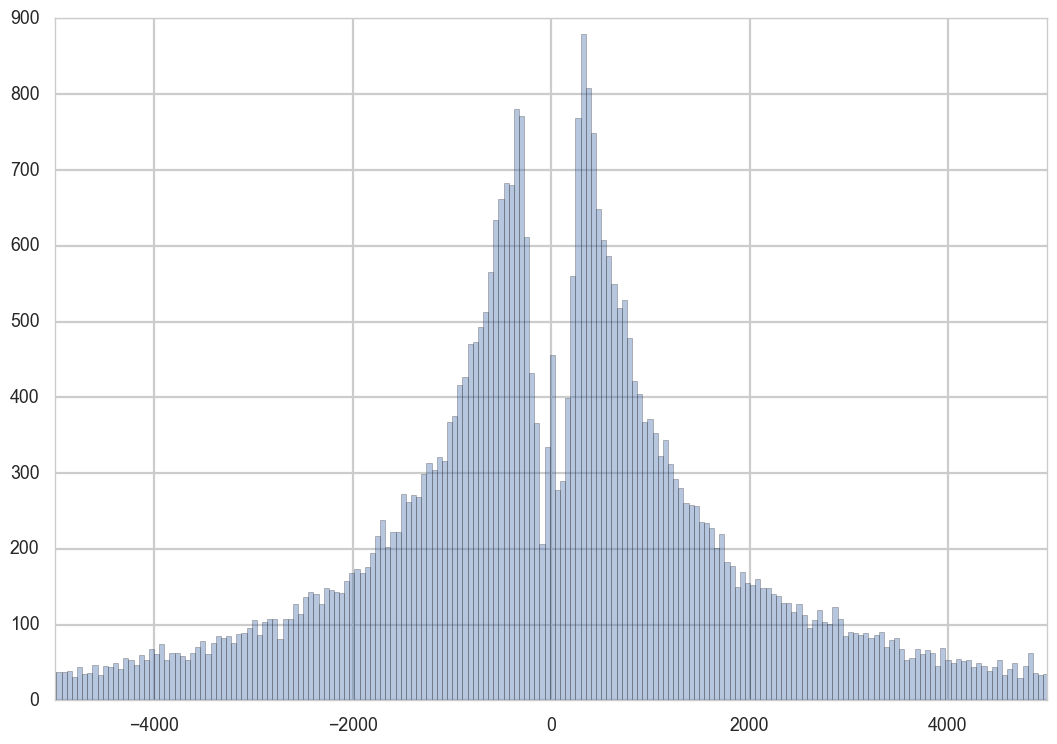

In [141]:
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 1})
g1 = sns.distplot(repeat_closeness_df[['centered_distance']], kde=False, bins=10000)
g1.set_xlim(-5000, 5000)